### Phase-based encoding in pairwise neural interactions

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate

In [14]:
dt = 1e-4 # Integration time-step
fs = 1 / dt # Sample frequency
f = 40 # Natural frequency 
a = 0 # Hopf-parameter
beta = 0 # Noise variance
A = np.array([[0, 1],[0, 0]]).T # Adjacency matrix
ntrials = 500
time = np.arange(-4, 4, dt) # Time array
T = time.shape[0]

In [15]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 1
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

In [26]:
data = []
for trial in tqdm(range(ntrials)):
    data += [ simulate(A, coupling * trial, f, a, fs, beta, T, seed = trial * 29279)  ]

  5%|███████▎                                                                                                                                          | 25/500 [00:04<01:25,  5.54it/s]


KeyboardInterrupt: 

In [22]:
data = np.stack(data)

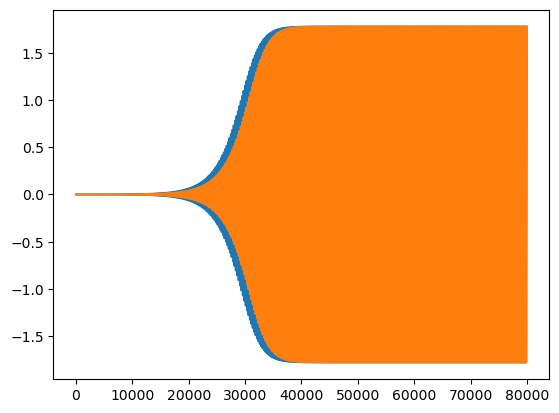

In [25]:
plt.plot( data[-1].real.T )